In [1]:
import os
import pandas as pd
import numpy as np

### 원본 학습 데이터 불러오기

In [3]:
data_dir = "../data"
preprocessed_output_dir = "../data/train-small-implicit" # where to be saved
standard = "../data/standard" # where to be loaded

In [4]:
data_df = pd.read_csv(os.path.join(standard, "train_ratebeer_without_text.csv"))

In [5]:
target_beer_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/db_files/db_target_beer.csv")
target_beer_list = target_beer_df["beer_id"].astype(int).tolist()

In [6]:
data_df.value_counts("user_id")

user_id
604      5999
568      5832
603      5517
562      5159
595      5121
         ... 
18617       1
42218       1
42217       1
42216       1
60585       1
Length: 54528, dtype: int64

In [7]:
data_df = data_df[data_df.beer_id.isin(target_beer_list)]
data_df.index = range(len(data_df))
data_df.tail(2)

,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,beer_id,brewer_id,abv,style,image_url,user_id
89385,2.8,2001-09-12T09:13:12.000Z,4.0,7.0,3.0,7.0,7.0,jbrus,Ambar Especial,8666,1474,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...,2009
89386,1.6,2001-08-11T14:31:27.000Z,3.0,2.0,2.0,3.0,6.0,Bov,Ambar Especial,8666,1474,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...,1771


### 2. 리뷰 개수가 1개인 유저 제거
- 리뷰 수가 1개인 유저는 모델이 학습하기에 적합하지 않은 데이터이기 때문에, 제외

In [8]:
tobe_deleted_users = (data_df.user_id.value_counts() <= 3).where(lambda x: x==True).dropna().index.tolist()

In [9]:
tobe_deleted_users
train_df = data_df[~data_df["user_id"].isin(tobe_deleted_users)]
train_df.index = range(len(train_df))
train_df.head(1)
print(len(train_df))

74493


<AxesSubplot:>

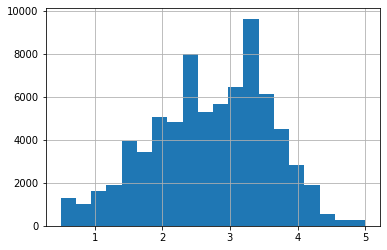

In [18]:
# explicit to implicit
train_df["review_score"].hist(bins=20)

In [23]:
score_Q1 = train_df["review_score"].describe()["25%"]
print("score_Q1:", score_Q1)

print("Ratio of number of preference beers: ", sum(train_df["review_score"] >= score_Q1)/len(train_df))
print("number of preference beers: ", sum(train_df["review_score"] >= score_Q1))

score_Q1: 2.1
Ratio of number of preference beers:  0.754889721181856
number of preference beers:  56234


In [22]:
sum(train_df["review_score"] >= score_Q1)

56234

In [24]:
implicit_df = train_df[train_df["review_score"] >= score_Q1]
implicit_df.index = range(len(implicit_df))
implicit_df.tail(2)

,review_score,review_time,appearance,aroma,palate,taste,overall,profile_name,beer_name,beer_id,brewer_id,abv,style,image_url,user_id
56232,2.4,2002-01-01T11:42:59.000Z,3.0,2.0,2.0,5.0,12.0,DavefromChicago,Ambar Especial,8666,1474,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...,7234
56233,2.8,2001-09-12T09:13:12.000Z,4.0,7.0,3.0,7.0,7.0,jbrus,Ambar Especial,8666,1474,5.2,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...,2009


In [28]:
tobe_deleted_users = (implicit_df.user_id.value_counts() <= 3).where(lambda x: x==True).dropna().index.tolist()
implicit_train_df = implicit_df[~implicit_df["user_id"].isin(tobe_deleted_users)]
implicit_train_df.index = range(len(implicit_train_df))
implicit_train_df.head(1)
print(len(implicit_train_df))

54341


In [29]:
# attribute extraction
style_df = implicit_train_df.groupby("beer_id")["beer_id", "style"].head(1)
style_df.index = range(len(style_df))
style_df.head(5)

<ipython-input-29-f837eab6eb52>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  style_df = implicit_train_df.groupby("beer_id")["beer_id", "style"].head(1)


,beer_id,style
0,37,Pale Lager - International / Premium
1,55,Stout
2,221,Pale Lager - International / Premium
3,251,Pale Lager - International / Premium
4,268,Pale Lager - International / Premium


In [31]:
array, index = pd.factorize(style_df["style"])
style_df["style"] = array
style_df.groupby("beer_id")["style"].apply(list).to_json(os.path.join(preprocessed_output_dir, "rb_item2attributes.json"))

### 데이터 전처리
- 모델 학습에 필요한 데이터를 제외

In [32]:
training_data = implicit_train_df[["user_id", "beer_id", "review_score", "review_time"]]
training_data.columns = ["user", "item", "rating", "time"]
training_data = training_data.sort_values(["user", "time"])
training_data.index = range(len(training_data))
training_data.isna().sum()

user      0
item      0
rating    0
time      0
dtype: int64

In [33]:
training_data.to_csv(os.path.join(preprocessed_output_dir, "train_ratings.csv"), index=False)